In [385]:
from google.colab import drive
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from PIL import Image, ImageChops
import os
import random
from scipy.stats import f_oneway, levene, shapiro, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skimage import io, color, transform
from skimage.transform import resize
import shutil
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import cv2



from sklearn.preprocessing import MinMaxScaler

In [386]:
# Montage de Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
image_folders = {
    "COVID": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images',
    "Normal": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Normal/images',
    "Lung_Opacity": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Lung_Opacity/images',
    "Viral_Pneumonia": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Viral_Pneumonia/images'
}

# Compter le nombre d'images dans chaque dossier
min_images_count = float('inf')  # Initialiser avec une valeur infinie
folder_with_min_images = None  # Initialiser avec None

for category, folder_path in image_folders.items():
    image_count = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
    if image_count < min_images_count:
        min_images_count = image_count
        folder_with_min_images = category

print("Le dossier avec le moins d'images est :", folder_with_min_images)
print("Nombre d'images dans ce dossier :", min_images_count)
'''

In [387]:
# Dossiers contenant les images et les masques pour chaque catégorie
image_folders = {
    "COVID": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images',
    "Normal": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Normal/images',
    "Lung_Opacity": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Lung_Opacity/images',
    "Viral_Pneumonia": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Viral_Pneumonia/images'
}

mask_folders = {
    "COVID": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks',
    "Normal": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Normal/masks',
    "Lung_Opacity": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Lung_Opacity/masks',
    "Viral_Pneumonia": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Viral_Pneumonia/masks'
}

# Nombre d'images à sélectionner par catégorie
images_per_category = 10

# Sélection aléatoire de 10 images de chaque catégorie
selected_image_mask_pairs = []

for category, image_folder_path in image_folders.items():
    mask_folder_path = mask_folders[category]
    image_files = [os.path.join(image_folder_path, file) for file in os.listdir(image_folder_path)]
    mask_files = [os.path.join(mask_folder_path, file) for file in os.listdir(mask_folder_path)]

    # Assurez-vous que les listes sont triées pour que les images et masques correspondent
    image_files.sort()
    mask_files.sort()

    selected_pairs = list(zip(image_files, mask_files))
    selected_image_mask_pairs.extend(selected_pairs)

In [397]:
selected_image_mask_pairs

[('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-133.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-2550.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-2018.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-1930.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-1930.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-1923.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-1923.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-2018.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-2550.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-133.png'),
 ('/content/drive/MyDr

In [389]:
class ImageMaskProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(299, 299)):
        self.target_size = target_size

    def fit(self, X, y=None):
        return self

    def transform(self, selected_image_mask_pairs):
        preprocessed_images = []
        preprocessed_masks = []

        for image_path, mask_path in selected_image_mask_pairs:
            # Charger l'image en niveaux de gris
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Redimensionner l'image à la taille spécifiée
            image = cv2.resize(image, self.target_size)
            # Normaliser les valeurs de pixel entre 0 et 1
            image = image.astype(np.float32) / 255.0
            # Ajouter un canal pour obtenir une forme (299, 299, 1)
            image = np.expand_dims(image, axis=-1)
            preprocessed_images.append(image)

            # Charger le masque en couleur (RGB)
            mask = cv2.imread(mask_path)
            # Redimensionner le masque à la taille spécifiée
            mask = cv2.resize(mask, self.target_size)
            # Convertir le masque en niveaux de gris
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # Normaliser les valeurs de pixel entre 0 et 1
            mask = mask.astype(np.float32) / 255.0
            # Ajouter un canal pour obtenir une forme (299, 299, 1)
            mask = np.expand_dims(mask, axis=-1)
            # Répéter le masque sur trois canaux pour correspondre aux images
            mask = np.repeat(mask, 3, axis=-1)
            preprocessed_masks.append(mask)

        return np.array(preprocessed_images), np.array(preprocessed_masks)

In [390]:
image_mask_processor_pipeline = Pipeline([
    ('process_images_masks', ImageMaskProcessor())
])

preprocessed_images, preprocessed_masks = image_mask_processor_pipeline.transform(selected_image_mask_pairs)

In [391]:
for i in range(len(preprocessed_masks)):
  print("Dimensions de l'image transformée :", preprocessed_images[i].shape)
  print("Dimensions du masque transformé :", preprocessed_masks[i].shape)

Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 1)
Dimensions du masque transformé : (299, 299, 3)
Dimensions de l'imag

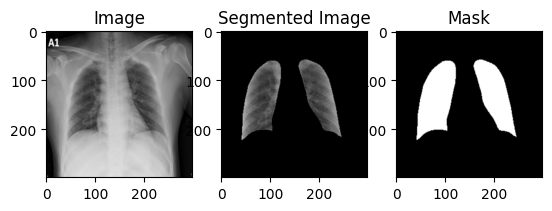

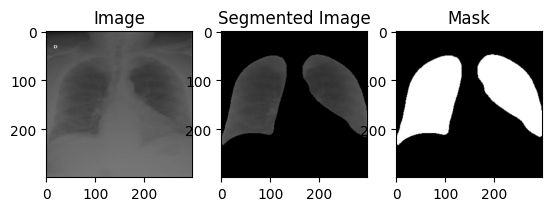

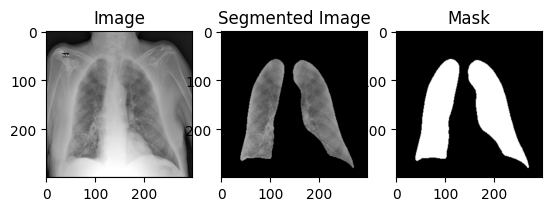

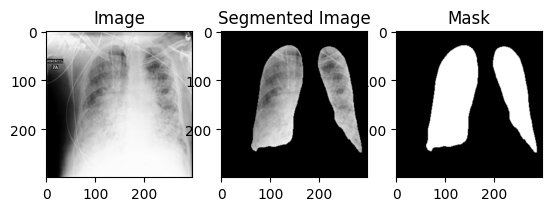

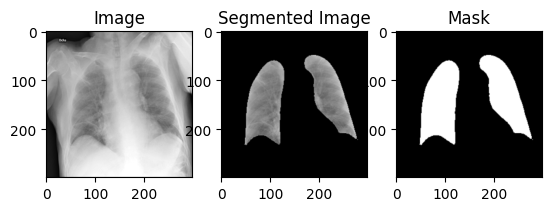

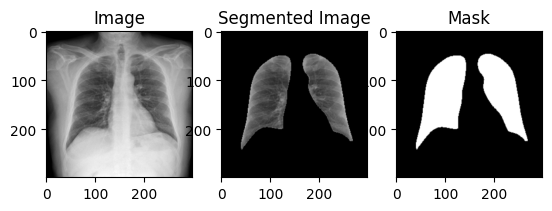

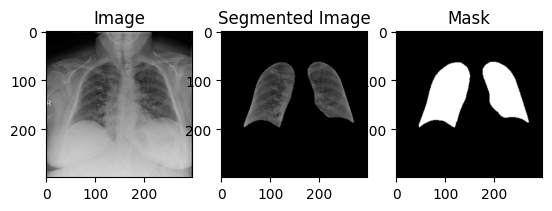

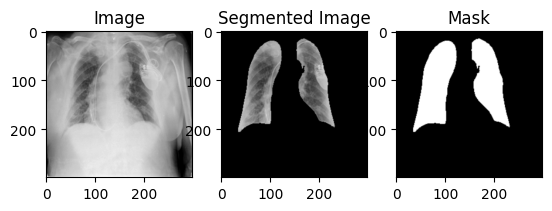

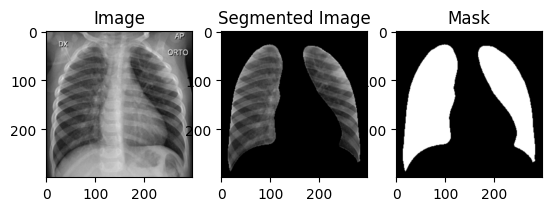

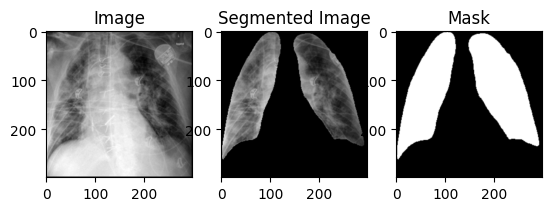

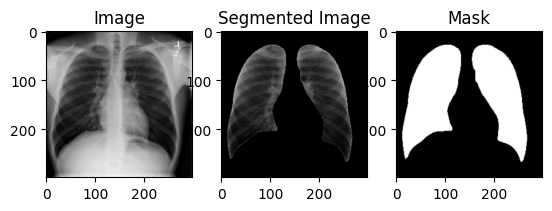

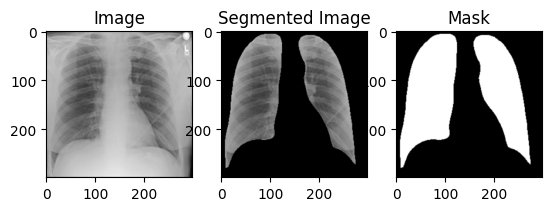

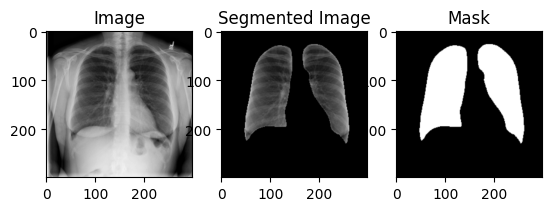

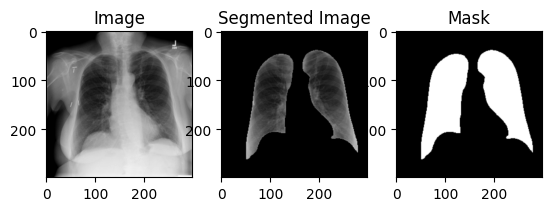

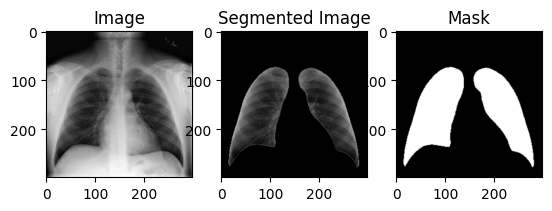

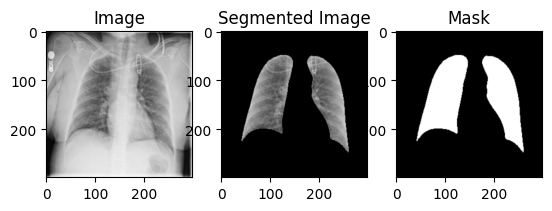

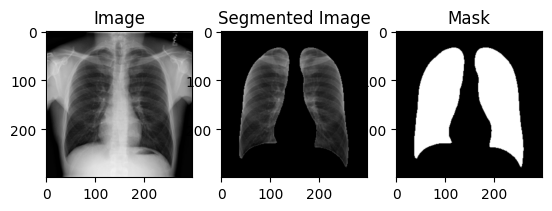

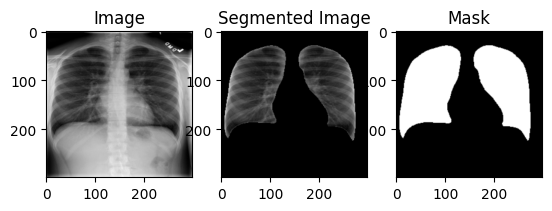

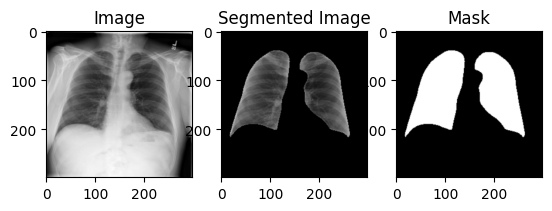

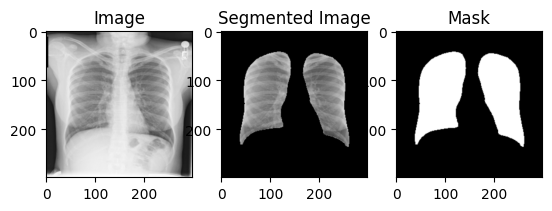

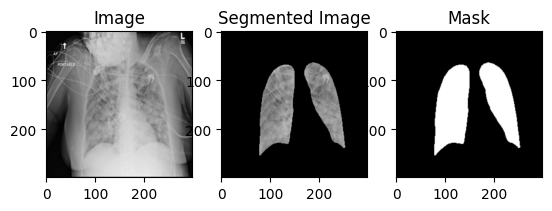

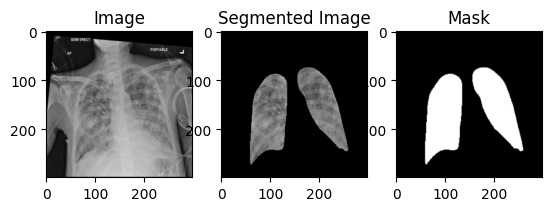

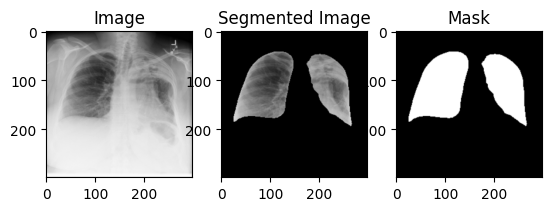

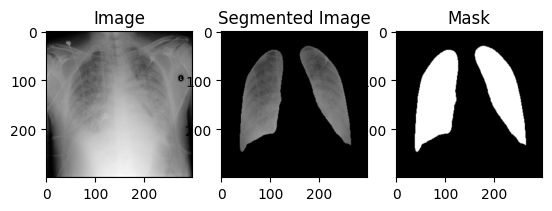

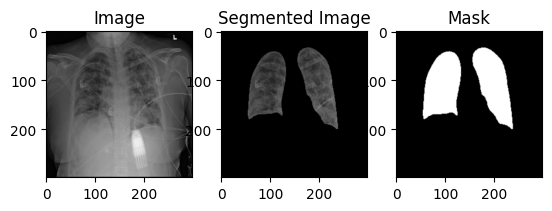

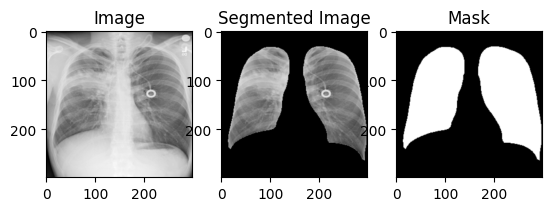

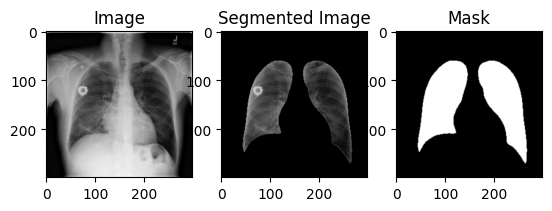

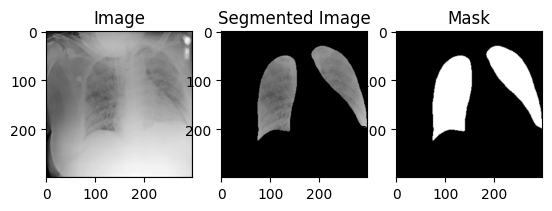

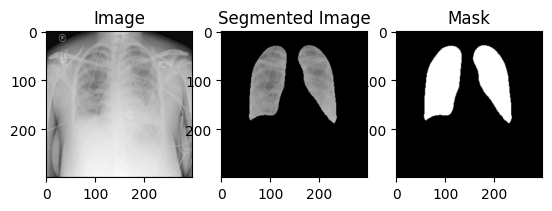

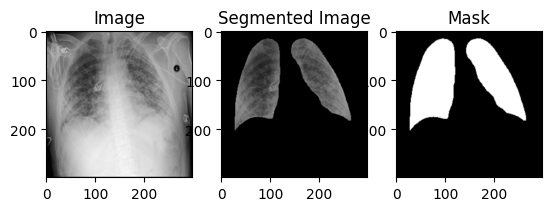

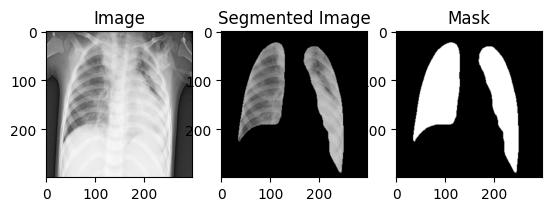

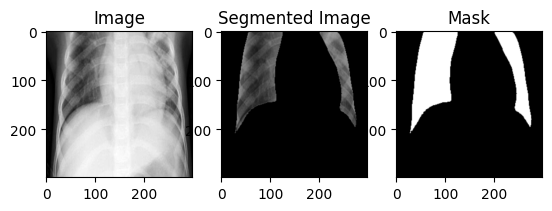

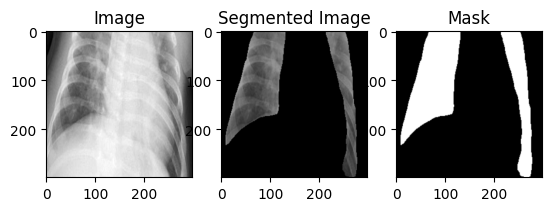

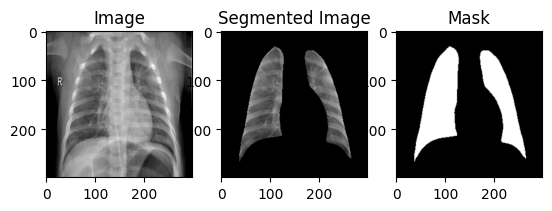

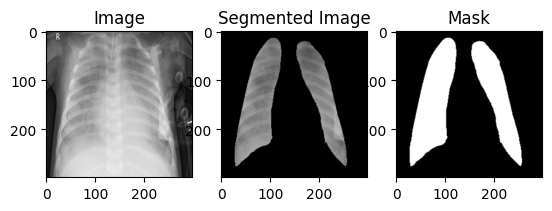

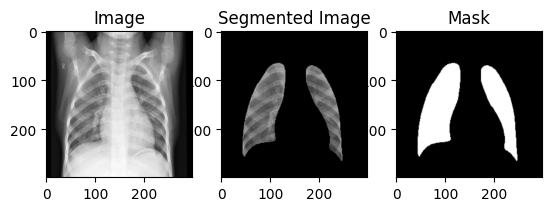

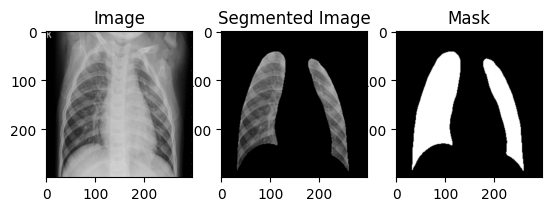

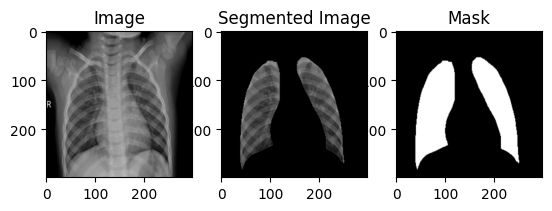

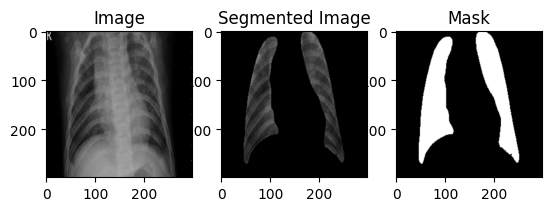

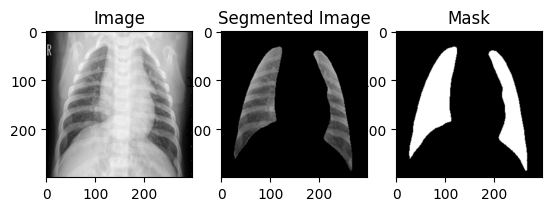

In [393]:
# Afficher les images segmentées
for i in range(len(preprocessed_images)):
    segmented_image = preprocessed_masks[i] * preprocessed_images[i]
    plt.subplot(1, 3, 1)
    plt.imshow(preprocessed_images[i],cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')

    plt.subplot(1, 3, 3)
    plt.imshow(preprocessed_masks[i])
    plt.title('Mask')

    plt.show()